In [8]:
import numpy as np
from scipy import fft as fft
from scipy.sparse.linalg import LinearOperator
from matplotlib import pyplot as plt
  
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'

class Operator(LinearOperator):
    def __init__(self, N=500, L=1):
        self.L = L
        self.N = N
        self.shape = (self.N,self.N)
        self.x = np.linspace(0, self.L, num=self.N, endpoint=False)

    
class FourierMultiplier(Operator):

    def __init__(self, transform='dct', **kwargs):
        super().__init__(**kwargs)
        self.dtype = None
        self.freqs = fft.fftfreq(self.N, d=self.L/self.N)
        self.multiplier = None ## Need to implement this on particular case
        self.transform = transform
        if self.transform == 'dct':
            self.fwd = fft.dct
            self.inv = fft.idct
            self.func = np.cos
        elif self.transform == 'dst':
            self.fwd = fft.dst
            self.inv = fft.idst
            self.func = np.sin
        elif self.transform == 'fft':
            self.fwd = np.fft.fft
            self.inv = np.fft.ifft
            self.func = lambda x: np.exp(2j*x)
            
    def eigenfunction(self, i):
        return lambda x: self.func(np.pi*self.freqs[i]*x)
        
    def eigenvector(self, i):
        v = self.eigenfunction(i)(self.x)
        return v / np.linalg.norm(v)
    
    def to_freq_domain(self, u, axis=-1):
        return self.fwd(u, axis=axis)/np.sqrt(self.N)
    
    def to_time_domain(self, u, axis=-1):
        return self.inv(u, axis=axis) * np.sqrt(self.N)
    
    def coeff2u(self, coeff):
        res = sum(coeff[i]*self.eigenfunction(i)(self.x) for i in np.where(np.abs(coeff) > 1e-5)[0])
        return res    
    
    def _matvec(self, v):
        return self(np.squeeze(v))
    
    def __call__(self, v, mult=None):
        if mult is None:
            mult = self.multiplier
        v_hat = self.to_freq_domain(v)
        Av_hat = v_hat * mult
        Av = self.to_time_domain(Av_hat) 
        return Av + np.mean(v)

    def random(self, return_coeffs=False, beta=1.137):
        if self.transform == 'fft':
            coeffs = np.random.randn(self.N, 2).view(np.complex128) 
            coeffs = np.squeeze(coeffs)
        else:
            coeffs = np.random.randn(self.freqs.size)
        coeffs /= (np.arange(coeffs.size)+1)**beta
        coeffs[0] = 0
        
        u0 = self.coeff2u(coeffs) 
        return u0, coeffs if return_coeffs else u0 
    
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return 'Fourier multiplier'
    
    
class Heat(FourierMultiplier):
    def __init__(self, time, alpha=1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.time = time
        self.multiplier = np.exp(-self.alpha * np.pi**2 * self.time * self.freqs**2)
          
    def __str__(self):
        return f'Heat operator alpha {alpha} time {time}'

class Laplacian(FourierMultiplier): ## Actually, negative Laplacian
    def __init__(self, gamma, **kwargs):
        super().__init__(**kwargs)
        multiplier = np.power(np.pi**2 * self.freqs**2, gamma)
        inv_mult = np.power(np.pi**2 * self.freqs**2, -gamma)
        ind = (multiplier < 1e-4) | (inv_mult < 1e-4) #| np.isnan(multiplier) | np.isnan(inv_mult) | (multiplier > 1e4) | (inv_mult > 1e4)
        ind[0] = True
        #ind[-1] = True
        multiplier[ind] = 0
        self.multiplier = multiplier
        inv_mult[ind] = 0
        self.inv_mult = inv_mult
        self.gamma = gamma
        self.kwargs = kwargs
        
    def inv(self):
        return Laplacian(gamma=-self.gamma, N=self.N, L=self.L)
    
    def __str__(self):
        return '$(-\Delta)^{' + str(self.gamma) + '}$'
            
    
class LinearFunctional(FourierMultiplier):
    def __init__(self, multiplier=None, **kwargs):
        super().__init__(**kwargs)
        self.multiplier = multiplier
    
    def __call__(self, v):
        return np.vdot(self.to_freq_domain(v), self.multiplier)
        

class PointObservation(LinearFunctional):
    def __init__(self, pt, **kwargs):
        super().__init__(**kwargs)
        self.pt = pt
        #delta = np.zeros(self.N)
        #ind = np.searchsorted(self.x, pt)
        #delta[ind] = 1
        #self.delta = delta
        #self.multiplier1 = self.to_freq_domain(delta)
        self.multiplier = np.array([self.eigenfunction(i)(-pt) for i in range(self.N)]) / np.sqrt(self.N)
        
    
    
class Observation(FourierMultiplier):
    def __init__(self, meas=[], functionals=[], **kwargs):
        super().__init__(**kwargs)
        self.meas = meas
        self.functionals = functionals
        self.operators = [PointObservation(m, **kwargs) for m in meas] + [LinearFunctional(func, **kwargs) for func in functionals]
        self.multiplier = np.zeros((len(meas) + len(functionals), self.N), dtype=np.complex128)
        for i, op in enumerate(self.operators):
            self.multiplier[i,:] = op.multiplier
           
    def obs_star_obs_multiplier(self):
        return np.dot(self.O_star, self.O)
        
    @property
    def O(self):
        return self.to_time_domain(self.multiplier)
        
    @property
    def O_star(self):
        return self.O.T.conj()
    
    def __call__(self, v):
        return np.einsum('ij, j -> i', self.multiplier, np.conj(self.to_freq_domain(v)))
    
    @property
    def singular_values(self):
        return np.linalg.svd(self.multiplier, compute_uv=False, full_matrices=False)

    
class DiagonalizableObservation(Observation):
    def __init__(self, singular_values, random_U=False, **kwargs):
        super().__init__(meas=[], functionals=[], **kwargs)
        del self.meas
        del self.functionals
        del self.operators
        singular_values = np.array(singular_values)
        assert len(singular_values.shape) == 1
        self.multiplier = np.zeros((singular_values.shape[0], self.N))
        np.fill_diagonal(self.multiplier, singular_values)
        if random_U:
            H = np.random.randn(singular_values.shape[0], singular_values.shape[0])
            Q, R = np.linalg.qr(H) # From https://stackoverflow.com/questions/38426349/how-to-create-random-orthonormal-matrix-in-python-numpy
            Q = np.vdot(Q, np.diag(np.sign(np.diag(R))))
            self.multiplier = np.dot(Q, self.multiplier)
            
            
    @property
    def obs_star_obs(self):
        return np.einsum('ij, jk -> ik', obs.O_star, obs.O)

class Precision(FourierMultiplier):
    def __init__(self, 
                 fwd, 
                 precision,
                 obs, 
                 sig):
        self.fwd = fwd
        self.prior = prior
        self.obs = obs
        self.sig = sig
        
        self.multiplier = precision.multiplier + sig**(-2) * fwd.multiplier**2 * obs.obs_star_obs_multiplier
        # precision = iFFT mltiplier FFT = iFFT multiplier iFFT* = FFT* (iFFT multiplier*)* 
        full = self.to_time_domain(np.diag(self.multiplier.conj()))
        full = full.T.conj()
        full = self.to_time_domain(full)
        self.full = full
                                        
                                        
    def __call__(self, v):
        self.prior.inverse(v) + self.sig**(-2) * self.fwd(self.obs.star_obs((self.fwd(v))))
        
class Covariance(FourierMultiplier):
    def __init__(self, 
                 fwd, 
                 prior,
                 obs, 
                 sig):
        self.fwd = fwd
        self.prior = prior
        self.obs = obs
        self.sig = sig
        self.precision = Precision(fwd=fwd, prior=prior, obs=obs, sig=sig)
        self.multiplier = 1 / self.precision.multiplier

   
    @property
    def utility(self):
        if type(self.obs) == DiagonalizableObservation:
            return self.diag_utility()
        else:
            return self.straight_utility()
            
    def straight_utility(self):
        prior12_fwd = self.prior.multiplier**(1/2) * self.fwd.multiplier
        Ostar_O = np.einsum('ki, kj -> ij', obs.multiplier.conj(), obs.multiplier)
        M = np.eye(self.N) + self.sig**(-2) * np.einsum 
        eigenvalues = sig**(-2) * fwd.multiplier**2 * prior.multiplier * obs

    def diag_utility(self):
        pass
        

<ipython-input-8-beb875f5ac90>:101: RuntimeWarning: divide by zero encountered in power
  multiplier = np.power(np.pi**2 * self.freqs**2, gamma)


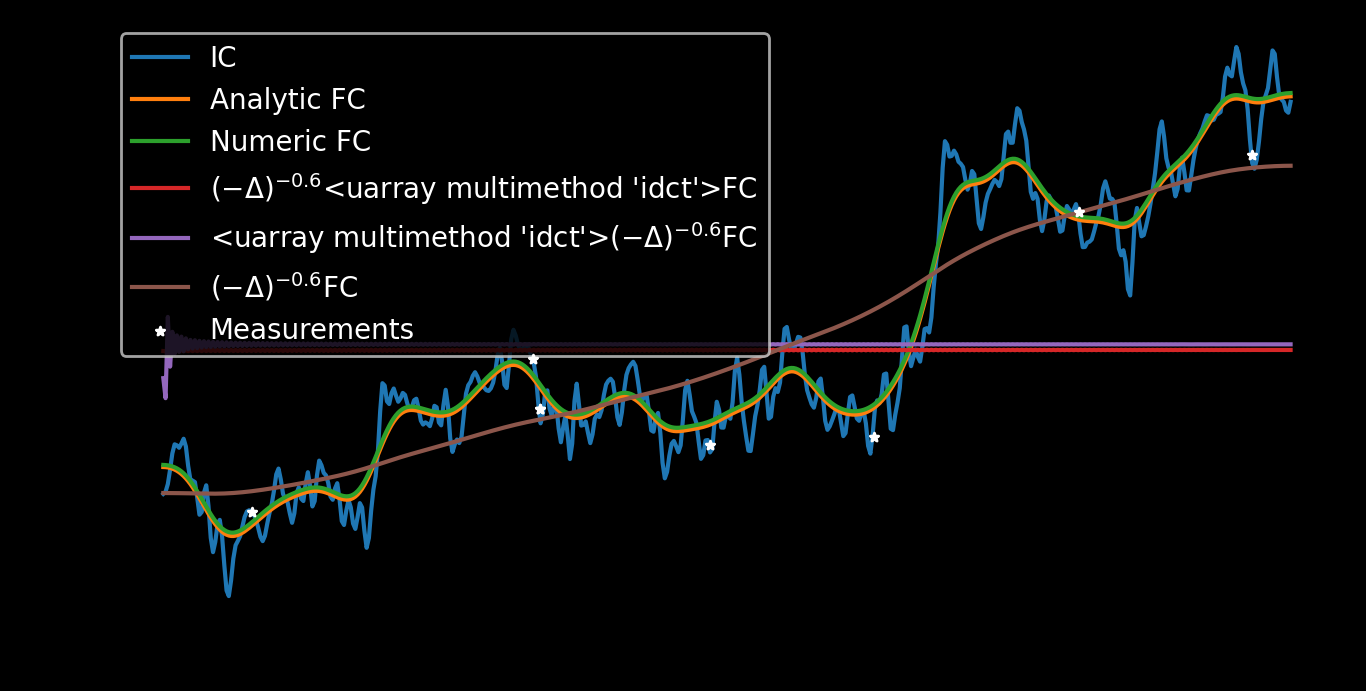

In [9]:
N = 500
L = 3
time = 2e-3
alpha = 0.6
beta = 1
gamma = -0.6
transform = 'dct'


fwd = Heat(N=N, L=L, alpha=alpha, time=time, transform=transform)
prior = Laplacian(gamma=gamma, N=N, L=L, transform=transform)
obs = Observation(meas=[0.2356323, 0.9822345, 1.451242, 1.886632215, 2.43244, 2.89235633, 1, 1], L=L, N=N, transform=transform)

# IC
u0, coeffs0 = fwd.random(return_coeffs=True, beta=beta)

# Analytic
coeffsT = coeffs0 * fwd.multiplier
uT = fwd.coeff2u(coeffsT)

# Numeric solution
uT_num = fwd(u0)
        
plt.plot(fwd.x, u0.real, label='IC')
plt.plot(fwd.x, uT.real, label='Analytic FC')
plt.plot(fwd.x, uT_num.real+0.02, label='Numeric FC')
plt.plot(prior.x, prior(prior.inv(uT))-0.02, label=str(prior) + str(prior.inv) + 'FC')
plt.plot(prior.x, prior.inv(prior(uT))+0.01, label= str(prior.inv) + str(prior) + 'FC')
plt.plot(prior.x, prior(uT), label= str(prior) + 'FC')
#plt.plot(prior.x, prior.inverse(uT), label= prior.inv_str + 'FC')
plt.scatter(obs.meas, obs(u0).real, label='Measurements', marker='*', s =10, color='w', zorder=10)

plt.legend()
#plt.close()

/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


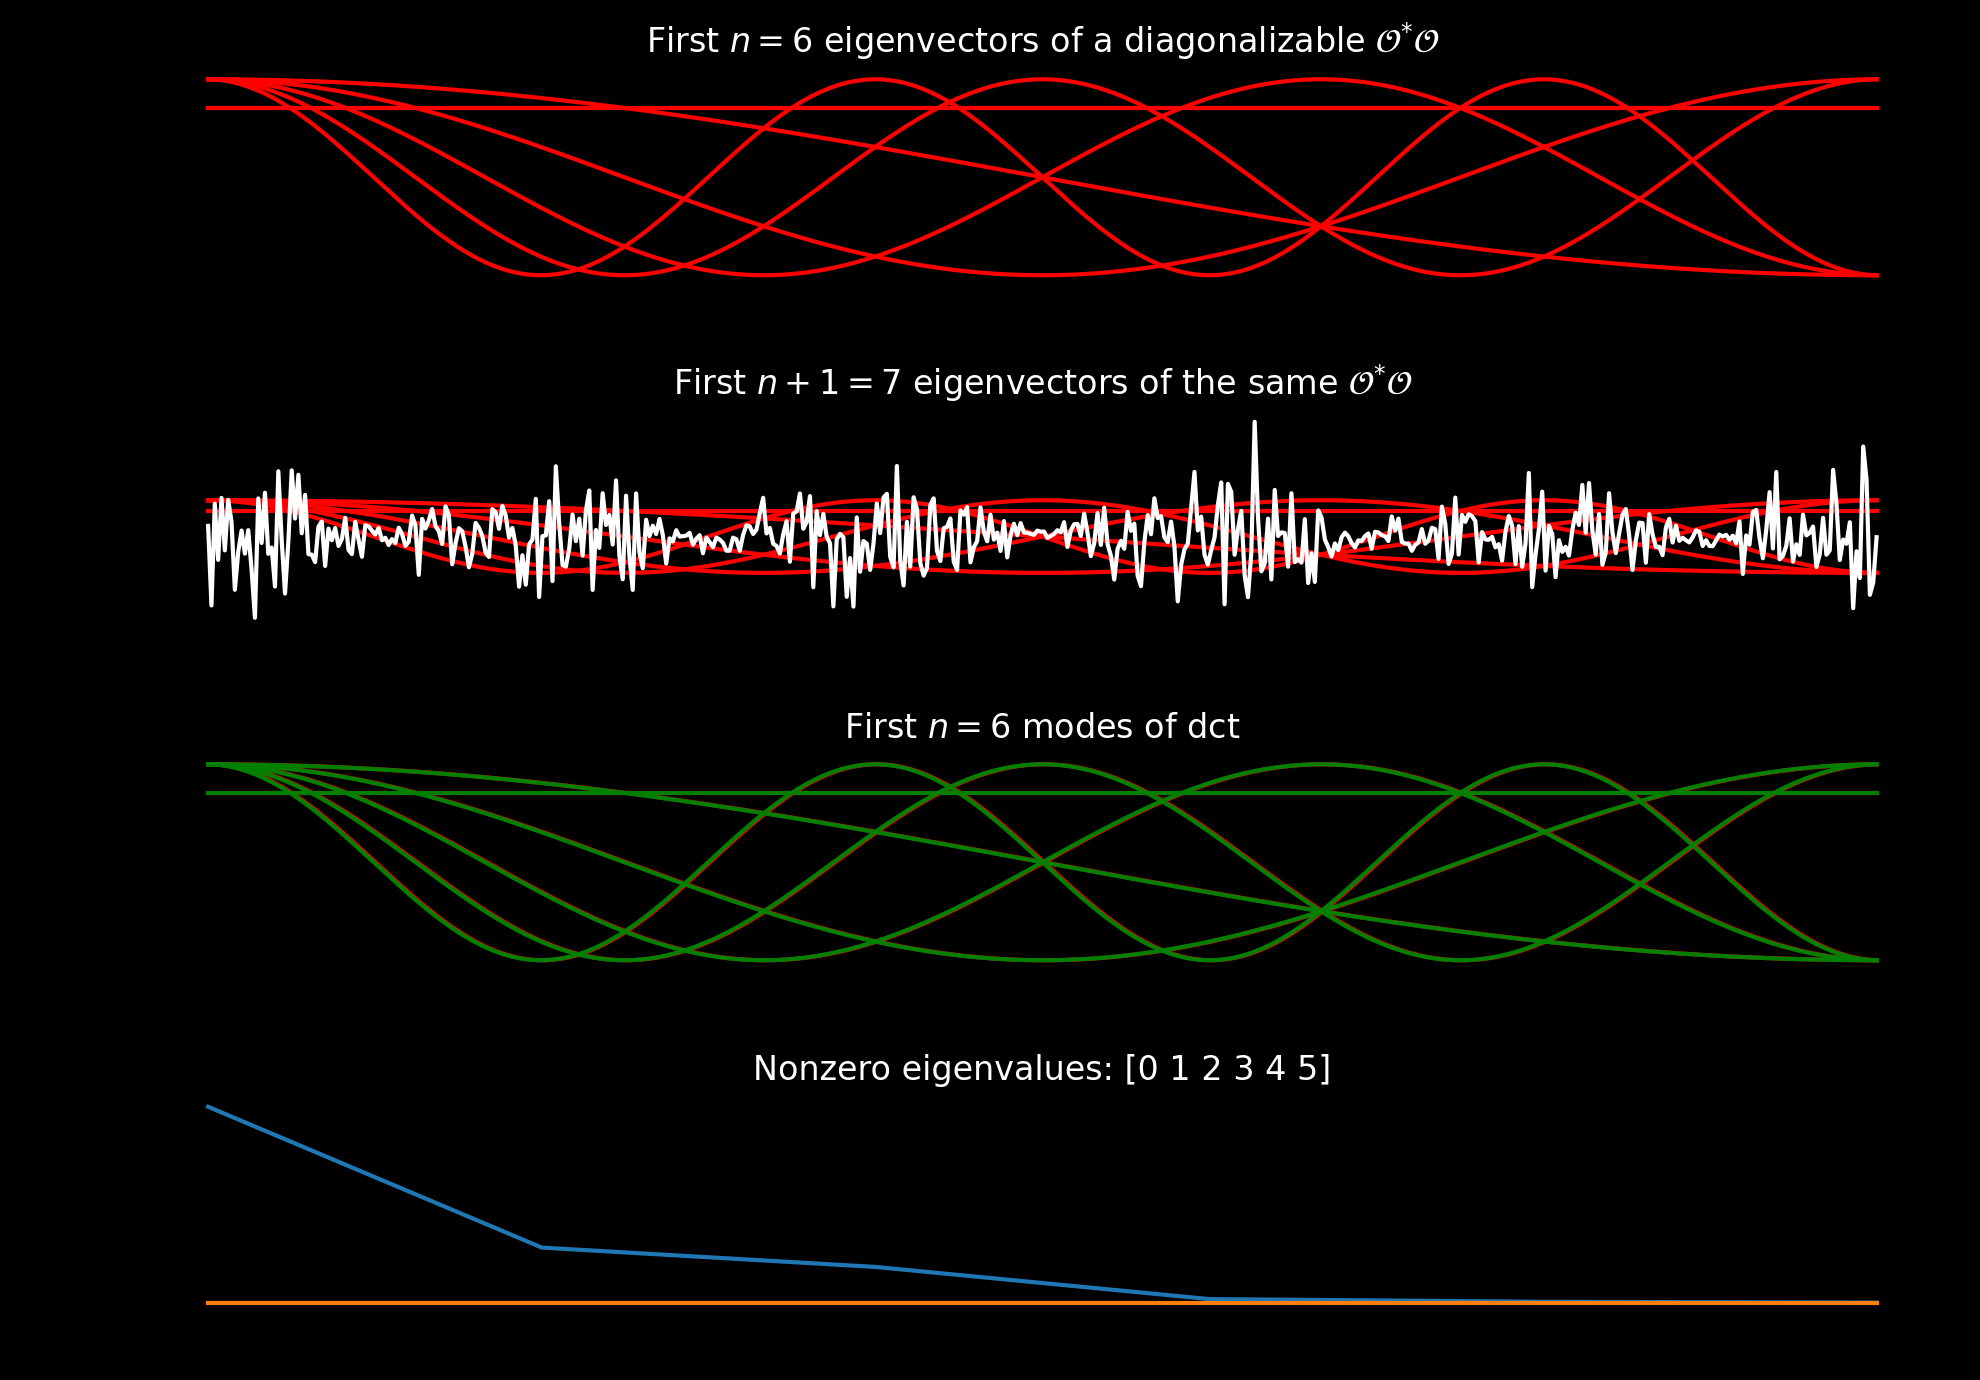

In [48]:
n = 6
singular_values = np.random.randn(n)**2
#singular_values[1] = 0
obs = DiagonalizableObservation(singular_values=singular_values,
                                N=500, 
                                random_U=True,
                                transform='dct')
D, P = np.linalg.eig(obs.obs_star_obs)
P = np.einsum('ij, j -> ij', P, np.sign(P[0,:]))
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,7))
for i in range(n):
    ax[0].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[1].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[2].plot(obs.x, obs.eigenvector(i), label=f'True {i}', color='r')
ax[1].plot(obs.x, P[:,i+1], label='$n+1$', color='w')

for i in range(n):
    ax[2].plot(obs.x, P[:,i].real, color='g')



# for axi in ax:
#     axi.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
#              ncol=1, fancybox=True, shadow=True)


OstarO = "$\mathcal{O}^{*}\mathcal{O}$"
ax[0].set_title(f"First $n={n}$ eigenvectors of a diagonalizable " + OstarO)
ax[1].set_title(f"First $n+1={n+1}$ eigenvectors of the same "  +OstarO)
ax[2].set_title(f"First $n={n}$ modes of {obs.transform}")


ind = np.where(np.abs(D) > 1e-9)[0]
ax[3].plot(np.arange(n), D[:n], label='$\mathbf{e}_i$')
ax[3].plot(np.arange(n), np.zeros(n), label='y=0')
ax[3].set_title(f"Nonzero eigenvalues: {ind}")

plt.tight_layout()
#plt.close()

In [49]:
cov = Precision(fwd=fwd, 
                precision=precision,
                obs=obs,
                sigma=0.1)

TypeError: __init__() got an unexpected keyword argument 'prior'

In [86]:
np.sum(D), np.sum(singular_values**2)

((0.08501885316744102+2.407412430484045e-34j), 0.27478144705777946)

In [92]:
np.sum(np.abs(D.imag))

1.727813105579849e-16

In [30]:
arr = np.array([[1 +3j, 2+5j], [3 + 3j, 2 -1j]])
arr = np.matrix(arr)
arr

matrix([[1.+3.j, 2.+5.j],
        [3.+3.j, 2.-1.j]])